# The Academy Awards, 1927 - 2023

Este [dataset](https://www.kaggle.com/datasets/unanimad/the-oscar-award) contiene un scraping de la base de datos de los Premios de la Academia, registros de los nominados y ganadores desde 1927 hasta 2023.

En este EDA cruzaré los datos de diferentes datasets de las películas con las nominadas y ganadoras a mejor pelicula para ver si los miembros de la academia siguen algun tipo de patron o *bias* para elegir la ganadora.

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import ast
import imdb
import seaborn as sns
import matplotlib.pyplot as plt


archivo = open("C:/Users/Nur/Documents/tokens/tmdb_token.txt", "r")
contenido = archivo.read()
archivo.close()
token = contenido

## EXPLORACIÓN INICIAL

In [2]:
df_oscars = pd.read_csv("./data/the_oscar_award.csv")
df_oscars

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10760,2022,2023,95,HONORARY AWARD,"To Euzhan Palcy, a masterful filmmaker who bro...",NaN,True
10761,2022,2023,95,HONORARY AWARD,"To Diane Warren, for her genius, generosity an...",NaN,True
10762,2022,2023,95,HONORARY AWARD,"To Peter Weir, a fearless and consummate filmm...",NaN,True
10763,2022,2023,95,GORDON E. SAWYER AWARD,Iain Neil,NaN,True


In [5]:
# Me quedo las categorías de mejor película

BEST_PICTURE = df_oscars.category == "BEST PICTURE"
OUTSTANDING_PICTURE =  df_oscars.category == "OUTSTANDING PICTURE"
OUTSTANDING_PRODUCTION = df_oscars.category == "OUTSTANDING PRODUCTION"
OUSTANDING_MOTION_PICTURE = df_oscars.category == "OUTSTANDING MOTION PICTURE"
BEST_MOTION_PICTURE = df_oscars.category == "BEST MOTION PICTURE"

df_best_picture = df_oscars[BEST_PICTURE | OUTSTANDING_PICTURE | OUTSTANDING_PRODUCTION | OUSTANDING_MOTION_PICTURE | BEST_MOTION_PICTURE].copy()
df_best_picture.drop(columns="category", inplace=True)

In [6]:
df_best_picture.info()

<class 'pandas.core.frame.DataFrame'>
Index: 591 entries, 19 to 10723
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      591 non-null    int64 
 1   year_ceremony  591 non-null    int64 
 2   ceremony       591 non-null    int64 
 3   name           591 non-null    object
 4   film           591 non-null    object
 5   winner         591 non-null    bool  
dtypes: bool(1), int64(3), object(2)
memory usage: 28.3+ KB


|columna|descripcion|
|-|-|
|year_film|Año de estreno|
|year_ceremony| Año en de la gala|
|ceremony|Número de ceremonia|
|name|Nombre de la productora/los productores|
|film|Título de la película|
|winner|Bool True si ganó|

## API TMDB

### Datos de las películas

El codigo siguiente divide el df en lotes de 50 por que es el número de requests que permite la API por segundo.  
Busca las películas por título y año y añade los datos a una lista de jsons.

In [13]:


movie_data = []
base_url = "https://api.themoviedb.org/3/search/movie?"

batches = np.array_split(df_best_picture, 11)  # Dividir en lotes
for batch in batches:
    for index, row in batch.iterrows():
        # Obtener el nombre de la película y el año de la fila actual
        name = row['film'].replace(" ", "%20")
        year = row['year_film']

        # Request
        url = f"{base_url}query={name}&include_adult=false&language=en-US&page=1&year={year}"

        headers = {
            "accept": "application/json",
            "Authorization": f"Bearer {token}"
        }
        response = requests.get(url, headers=headers)

        # Buscar la primera coincidencia exacta en los resultados
        found = False
        for result in response.json()['results']:
            if result['title'].lower() == row['film'].lower():
                movie_data.append(result)
                found = True
                break  # Salir del bucle después de encontrar la primera coincidencia

        # Si no se encuentra coincidencia exacta le sumo 1 al año
        if not found:
            year = row['year_film']+1

            url = f"{base_url}query={name}&include_adult=false&language=en-US&page=1&year={year}"

            headers = {
                "accept": "application/json",
                "Authorization": f"Bearer {token}"
            }
            response = requests.get(url, headers=headers)

            found = False
            for result in response.json()['results']:
                if result['title'].lower() == row['film'].lower():
                    movie_data.append(result)
                    found = True
                    break
            
            # Si sigue sin encontrarse le resto 1 al año
            if not found:
                year = row['year_film']-1

                url = f"{base_url}query={name}&include_adult=false&language=en-US&page=1&year={year}"

                headers = {
                    "accept": "application/json",
                    "Authorization": f"Bearer {token}"
                }
                response = requests.get(url, headers=headers)

                found = False
                for result in response.json()['results']:
                    if result['title'].lower() == row['film'].lower():
                        movie_data.append(result)
                        found = True
                        break
                # Para saber ver que peli exactamente es la que no me encuentra los datos    
                if not found:
                    movie_data.append({"title": f"{row['film']}",
                                    "release_date": f"{row['year_film']}"})

movie_data

c:\Users\Nur\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[{'adult': False,
  'backdrop_path': '/yCpYVgJH7d49vDc44SKrHLEVhcq.jpg',
  'genre_ids': [80, 18],
  'id': 27777,
  'original_language': 'en',
  'original_title': 'The Racket',
  'overview': 'A renegade police captain sets out to catch a sadistic mob boss.',
  'popularity': 3.169,
  'poster_path': '/wHAJfHslSb6OpNQmj1hu9aE9IQR.jpg',
  'release_date': '1928-11-01',
  'title': 'The Racket',
  'video': False,
  'vote_average': 6.4,
  'vote_count': 29},
 {'adult': False,
  'backdrop_path': '/ebgjvr2dwubTYzOfa419bAzumQ0.jpg',
  'genre_ids': [18, 10749],
  'id': 82474,
  'original_language': 'en',
  'original_title': '7th Heaven',
  'overview': 'A dejected Parisian sewer worker feels his prayers have been answered when he falls in love with a street waif.',
  'popularity': 7.41,
  'poster_path': '/3ETXMu5PrcVMRJpfN2Z3MwcfXzy.jpg',
  'release_date': '1927-09-10',
  'title': '7th Heaven',
  'video': False,
  'vote_average': 7.3,
  'vote_count': 90},
 {'adult': False,
  'backdrop_path': '/soJGAj

In [26]:
df_movie_data = pd.DataFrame(movie_data)
df_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              591 non-null    bool   
 1   backdrop_path      591 non-null    object 
 2   genre_ids          591 non-null    object 
 3   id                 591 non-null    int64  
 4   original_language  591 non-null    object 
 5   original_title     591 non-null    object 
 6   overview           591 non-null    object 
 7   popularity         591 non-null    float64
 8   poster_path        591 non-null    object 
 9   release_date       591 non-null    object 
 10  title              591 non-null    object 
 11  video              591 non-null    bool   
 12  vote_average       591 non-null    float64
 13  vote_count         591 non-null    int64  
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 56.7+ KB


In [27]:
df_movie_data.drop(columns=["adult", "backdrop_path", "id", "poster_path", "video", "vote_count", "popularity"], inplace=True)

In [28]:
df_movie_data['release_date'] = pd.to_datetime(df_movie_data['release_date'])
df_movie_data

,genre_ids,original_language,original_title,overview,release_date,title,vote_average
0,"[80, 18]",en,The Racket,A renegade police captain sets out to catch a ...,1928-11-01,The Racket,6.400
1,"[18, 10749]",en,7th Heaven,A dejected Parisian sewer worker feels his pra...,1927-09-10,7th Heaven,7.300
2,"[18, 28, 10752, 10749]",en,Wings,"Two young men, one rich, one middle class, bot...",1927-08-12,Wings,7.205
3,"[28, 80, 53]",en,Alibi,"Chick Williams, a prohibition gangster, rejoin...",1929-04-20,Alibi,5.656
4,"[28, 37]",en,In Old Arizona,Army Sergeant Mickey Dunn sets out in pursuit ...,1928-12-25,In Old Arizona,5.208
...,...,...,...,...,...,...,...
586,[18],en,The Fabelmans,"Growing up in post-World War II era Arizona, y...",2022-11-11,The Fabelmans,7.700
587,"[18, 10402]",en,TÁR,Renowned musician Lydia Tár is days away from ...,2022-09-23,TÁR,7.146
588,"[28, 18]",en,Top Gun: Maverick,After more than thirty years of service as one...,2022-05-24,Top Gun: Maverick,8.236
589,"[35, 18]",en,Triangle of Sadness,A celebrity model couple are invited on a luxu...,2022-09-18,Triangle of Sadness,7.112


#### Géneros

In [29]:
# OBTENGO LAS CLAVES DE LOS GÉNEROS

url = "https://api.themoviedb.org/3/genre/movie/list?language=en"

headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {token}"
}

response = requests.get(url, headers=headers)

genres = response.json()

In [30]:
# Y LOS CONVIERTO A DICCIONARIO

dict_genres = {}

for i in genres["genres"]:
    id = i["id"]
    name = i["name"]
    dict_genres[id] = name

dict_genres

{28: 'Action',
 12: 'Adventure',
 16: 'Animation',
 35: 'Comedy',
 80: 'Crime',
 99: 'Documentary',
 18: 'Drama',
 10751: 'Family',
 14: 'Fantasy',
 36: 'History',
 27: 'Horror',
 10402: 'Music',
 9648: 'Mystery',
 10749: 'Romance',
 878: 'Science Fiction',
 10770: 'TV Movie',
 53: 'Thriller',
 10752: 'War',
 37: 'Western'}

In [ ]:
# CREO LA COLUMNA CON LOS NOMBRES DE LOS GENEROS Y ME QUITO LA COLUMNA DE LOS IDS

df_movie_data['genre'] = None

for index, row in df_movie_data.iterrows():
    string = row["genre_ids"]
    
    # Convertir la string a una lista
    lista_ids = ast.literal_eval(string)
    
    # Mapear cada ID a su nombre de género
    genre_nombres = [dict_genres.get(i) for i in lista_ids]
    
    # Asignar la lista resultante a la columna 'genre'
    df_movie_data.at[index, "genre"] = genre_nombres

df_movie_data.drop(columns="genre_ids", inplace=True)

In [52]:
# no se por que no me funciona ast pero el resultado de la celda anterior es este:
df_movie_data = pd.read_csv("./data/movie_data_final.csv")
df_movie_data

,original_language,original_title,overview,release_date,title,vote_average,genre
0,en,The Racket,A renegade police captain sets out to catch a ...,1928-11-01,The Racket,6.400,"['Crime', 'Drama']"
1,en,7th Heaven,A dejected Parisian sewer worker feels his pra...,1927-09-10,7th Heaven,7.317,"['Drama', 'Romance']"
2,en,Wings,"Two young men, one rich, one middle class, bot...",1927-08-12,Wings,7.198,"['Drama', 'Action', 'War', 'Romance']"
3,en,Alibi,"Chick Williams, a prohibition gangster, rejoin...",1929-04-20,Alibi,5.656,"['Action', 'Crime', 'Thriller']"
4,en,In Old Arizona,Army Sergeant Mickey Dunn sets out in pursuit ...,1928-12-25,In Old Arizona,5.208,"['Action', 'Western']"
...,...,...,...,...,...,...,...
586,en,The Fabelmans,"Growing up in post-World War II era Arizona, y...",2022-11-11,The Fabelmans,7.692,"['Drama', 'Comedy']"
587,en,TÁR,Renowned musician Lydia Tár is days away from ...,2022-09-23,TÁR,7.143,"['Drama', 'Music']"
588,en,Top Gun: Maverick,After more than thirty years of service as one...,2022-05-24,Top Gun: Maverick,8.237,"['Action', 'Drama']"
589,en,Triangle of Sadness,A celebrity model couple are invited on a luxu...,2022-09-18,Triangle of Sadness,7.116,"['Comedy', 'Drama']"


## IMDB
El siguiente código usa la librería de IMDB para buscar las películas y quedarnos con los ratings y la duración  

*Las siguientes celdas son dos requests que tardan una hora, por tanto estan comentadas*

### Ratings

In [ ]:
# ia = imdb.IMDb()
# lista_ratings = []

# for index, row in df_best_picture.iterrows():
#     name = row['film']
#     year = row['year_film']

#     # Encontrar la pelicula exacta
#     pelicula_exacta = None
#     for resultado in ia.search_movie(name, year):
#         if resultado.get('title', '').lower() == name.lower() and resultado.get('year') == year:
#             pelicula_exacta = resultado
#             break
#         # si no la encuentra mirar año arriba / año abajo
#         elif resultado.get('title', '').lower() == name.lower() and resultado.get('year') in [year - 1, year + 1]:
#             pelicula_exacta = resultado
#             break
# # si encuentra la pelicula exacta crear un diccionario y meterlo en una lista
#     if pelicula_exacta:
#         ia.update(pelicula_exacta)
#         rating = pelicula_exacta.get('rating', None)
#         movie_title = pelicula_exacta.get('title', None)
#         dict_entry = {'title': movie_title, 'rating': rating}
#         lista_ratings.append(dict_entry)
#     else:
#         dict_entry = {'title': None, 'rating': None}
#         lista_ratings.append(dict_entry)


### Duración

In [ ]:
# lista_duracion = []

# for index, row in df_best_picture.iterrows():
#     name = row['film']
#     year = row['year_film']

#     pelicula_exacta = None
#     for resultado in ia.search_movie(name, year):
#         if resultado.get('title', '').lower() == name.lower() and resultado.get('year') == year:
#             pelicula_exacta = resultado
#             break
#         elif resultado.get('title', '').lower() == name.lower() and resultado.get('year') in [year - 1, year + 1]:
#             pelicula_exacta = resultado
#             break

#     if pelicula_exacta:
#         ia.update(pelicula_exacta, info=['main'])
#         duration = pelicula_exacta.get('runtimes', [None])[0]
#         movie_title = pelicula_exacta.get('title', None)
#         dict_entry = {'title': movie_title, 'duration': duration}
#         lista_duracion.append(dict_entry)
#     else:
#         dict_entry = {'title': None, 'duration': None}
#         lista_duracion.append(dict_entry)


In [ ]:
# Pasamos las listas de diccionarios a df

# df_ratings = pd.DataFrame(lista_ratings)
# df_duracion = pd.DataFrame(lista_duracion)

In [ ]:
# Concatenamos los dfs horizontalmente y me quito todas las columan llamadas title

# df_final = pd.concat([df_best_picture, df_movie_data, df_ratings, df_duracion], axis=1)

In [101]:
# Este seria el resultado de todas las celdas comentadas
df_final = pd.read_csv("./data/df_final.csv")
df_final

,year_film,year_ceremony,ceremony,film,winner,original_language,original_title,release_date,vote_average,genre,rating,duration
0,1927,1928,1,The Racket,False,en,The Racket,1928-11-01,6.400,"['Crime', 'Drama']",6.6,84.0
1,1927,1928,1,7th Heaven,False,en,7th Heaven,1927-09-10,7.317,"['Drama', 'Romance']",7.6,110.0
2,1927,1928,1,Wings,True,en,Wings,1927-08-12,7.198,"['Drama', 'Action', 'War', 'Romance']",7.5,144.0
3,1928,1929,2,Alibi,False,en,Alibi,1929-04-20,5.656,"['Action', 'Crime', 'Thriller']",5.7,91.0
4,1928,1929,2,In Old Arizona,False,en,In Old Arizona,1928-12-25,5.208,"['Action', 'Western']",5.5,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...
586,2022,2023,95,The Fabelmans,False,en,The Fabelmans,2022-11-11,7.692,"['Drama', 'Comedy']",7.5,151.0
587,2022,2023,95,Tár,False,en,TÁR,2022-09-23,7.143,"['Drama', 'Music']",7.4,158.0
588,2022,2023,95,Top Gun: Maverick,False,en,Top Gun: Maverick,2022-05-24,8.237,"['Action', 'Drama']",8.3,130.0
589,2022,2023,95,Triangle of Sadness,False,en,Triangle of Sadness,2022-09-18,7.116,"['Comedy', 'Drama']",7.3,147.0


In [102]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year_film          591 non-null    int64  
 1   year_ceremony      591 non-null    int64  
 2   ceremony           591 non-null    int64  
 3   film               591 non-null    object 
 4   winner             591 non-null    bool   
 5   original_language  591 non-null    object 
 6   original_title     591 non-null    object 
 7   release_date       591 non-null    object 
 8   vote_average       591 non-null    float64
 9   genre              591 non-null    object 
 10  rating             581 non-null    float64
 11  duration           582 non-null    float64
dtypes: bool(1), float64(3), int64(3), object(5)
memory usage: 51.5+ KB


### Limpieza

### Ratings


In [103]:
# veo cuales son las pelis con nulos para dirigir un poco el empujon a la request

ratings_nulos = df_final[df_final["rating"].isna()]
ratings_nulos

,year_film,year_ceremony,ceremony,film,winner,original_language,original_title,release_date,vote_average,genre,rating,duration
7,1928,1929,2,The Patriot,False,en,The Patriot,1928-09-01,5.000,['Drama'],NaN,113.0
85,1938,1939,11,Grand Illusion,False,fr,La Grande Illusion,1937-06-04,7.858,"['Drama', 'History', 'War']",NaN,NaN
151,1946,1947,19,Henry V,False,en,The Chronicle History of King Henry the Fifth ...,1944-11-24,6.604,"['Drama', 'History', 'War']",NaN,NaN
174,1950,1951,23,Sunset Boulevard,False,en,Sunset Boulevard,1950-08-17,8.322,['Drama'],NaN,NaN
200,1956,1957,29,Around the World in Eighty Days,True,en,Around the World in Eighty Days,1956-10-17,6.664,"['Adventure', 'Comedy', 'Family', 'Fantasy', '...",NaN,NaN
252,1966,1967,39,The Russians Are Coming! The Russians Are Coming!,False,en,The Russians Are Coming! The Russians Are Coming!,1966-05-25,6.300,"['Comedy', 'War']",NaN,NaN
286,1973,1974,46,Cries and Whispers,False,sv,Viskningar och rop,1972-12-21,7.939,['Drama'],NaN,NaN
308,1977,1978,50,Star Wars,False,en,Star Wars,1977-05-25,8.205,"['Adventure', 'Action', 'Science Fiction']",NaN,NaN
369,1989,1990,62,My Left Foot: The Story of Christy Brown,False,en,My Left Foot: The Story of Christy Brown,1989-04-07,7.521,['Drama'],NaN,NaN
561,2019,2020,92,Once Upon a Time… in Hollywood,False,en,Once Upon a Time… in Hollywood,2019-07-24,7.439,"['Comedy', 'Drama', 'Thriller']",NaN,NaN


In [104]:
# este código es igual que el anterior solo que no le pido que el título
# encontrado y el título del df sean exactamente iguales
# ademas coloco el rating directamente en el df

ia = imdb.IMDb()
for index, row in df_final.iterrows():
    if pd.isna(row["rating"]):
        film = row["film"]
        year = row["year_film"]

        movie_search = ia.search_movie(film, year)

        matching_movie = None
        for result in movie_search:
            # IMDb movies may not have a 'year' attribute, so we need to check its existence
            if "year" in result and abs(result["year"] - year) <= 2:
                matching_movie = result
                break
        if matching_movie:
            movie_id = matching_movie.movieID
            movie = ia.get_movie(movie_id)

            # Access the rating information
            rating = movie.data.get('rating', None)

            # Update the DataFrame with the retrieved rating
            df_final.at[index, 'rating'] = rating
        

In [105]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year_film          591 non-null    int64  
 1   year_ceremony      591 non-null    int64  
 2   ceremony           591 non-null    int64  
 3   film               591 non-null    object 
 4   winner             591 non-null    bool   
 5   original_language  591 non-null    object 
 6   original_title     591 non-null    object 
 7   release_date       591 non-null    object 
 8   vote_average       591 non-null    float64
 9   genre              591 non-null    object 
 10  rating             590 non-null    float64
 11  duration           582 non-null    float64
dtypes: bool(1), float64(3), int64(3), object(5)
memory usage: 51.5+ KB


In [106]:
# como solo queda un nulo lo relleno con el valor de vote_average que hemos sacado de tmdb
df_final['rating'] = df_final['rating'].fillna(df_final['vote_average'])

### Duracion

In [108]:
# hago lo mismo con las duraciones

ia = imdb.IMDb()
for index, row in df_final.iterrows():
    if pd.isna(row["duration"]):
        film = row["film"]
        year = row["year_film"]

        movie_search = ia.search_movie(film, year)

        matching_movie = None
        for result in movie_search:
            if "year" in result and abs(result["year"] - year) <= 2:
                matching_movie = result
                break
        if matching_movie:
            movie_id = matching_movie.movieID
            movie = ia.get_movie(movie_id)

            duration = movie.data.get('runtimes', None)

            df_final.at[index, 'duration'] = duration
        

In [109]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year_film          591 non-null    int64  
 1   year_ceremony      591 non-null    int64  
 2   ceremony           591 non-null    int64  
 3   film               591 non-null    object 
 4   winner             591 non-null    bool   
 5   original_language  591 non-null    object 
 6   original_title     591 non-null    object 
 7   release_date       591 non-null    object 
 8   vote_average       591 non-null    float64
 9   genre              591 non-null    object 
 10  rating             591 non-null    float64
 11  duration           591 non-null    object 
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 51.5+ KB


In [113]:
# a partir de aqui cargo el df que tengo guardado porsi
df = pd.read_csv("./data/final_final.csv")

# relleno el nulo q queda con el vote avg de tmdb
df['rating'] = df['rating'].fillna(df['vote_average'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year_film          591 non-null    int64  
 1   year_ceremony      591 non-null    int64  
 2   ceremony           591 non-null    int64  
 3   film               591 non-null    object 
 4   winner             591 non-null    bool   
 5   original_language  591 non-null    object 
 6   original_title     591 non-null    object 
 7   release_date       591 non-null    object 
 8   vote_average       591 non-null    float64
 9   genre              591 non-null    object 
 10  rating             591 non-null    float64
 11  duration           591 non-null    object 
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 51.5+ KB


In [117]:
# paso las fechas a datetime
df['release_date'] = pd.to_datetime(df['release_date'])

In [114]:
# paso genre a lista

df['genre'] = df['genre'].apply(ast.literal_eval)

In [115]:
# paso duration a float
df['duration'] = df['duration'].str.strip("[]'").str.replace(',', '.').astype(float)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   year_film          591 non-null    int64         
 1   year_ceremony      591 non-null    int64         
 2   ceremony           591 non-null    int64         
 3   film               591 non-null    object        
 4   winner             591 non-null    bool          
 5   original_language  591 non-null    object        
 6   original_title     591 non-null    object        
 7   release_date       591 non-null    datetime64[ns]
 8   vote_average       591 non-null    float64       
 9   genre              591 non-null    object        
 10  rating             591 non-null    float64       
 11  duration           591 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 51.5+ KB


## Análisis

In [119]:
# divido las peliculas por eras

eras_bins = [1927, 1955, 1977, 2000, float('inf')]
eras_labels = ['Golden Era', 'The Change', 'Modern Era', 'New Millennium']

df['era'] = pd.cut(df['year_film'], bins=eras_bins, labels=eras_labels, right=False)

golden_era = df[df['era'] == 'Golden Era']
the_change = df[df['era'] == 'The Change']
modern_era = df[df['era'] == 'Modern Era']
new_millennium = df[df['era'] == 'New Millennium']

### Género por eras

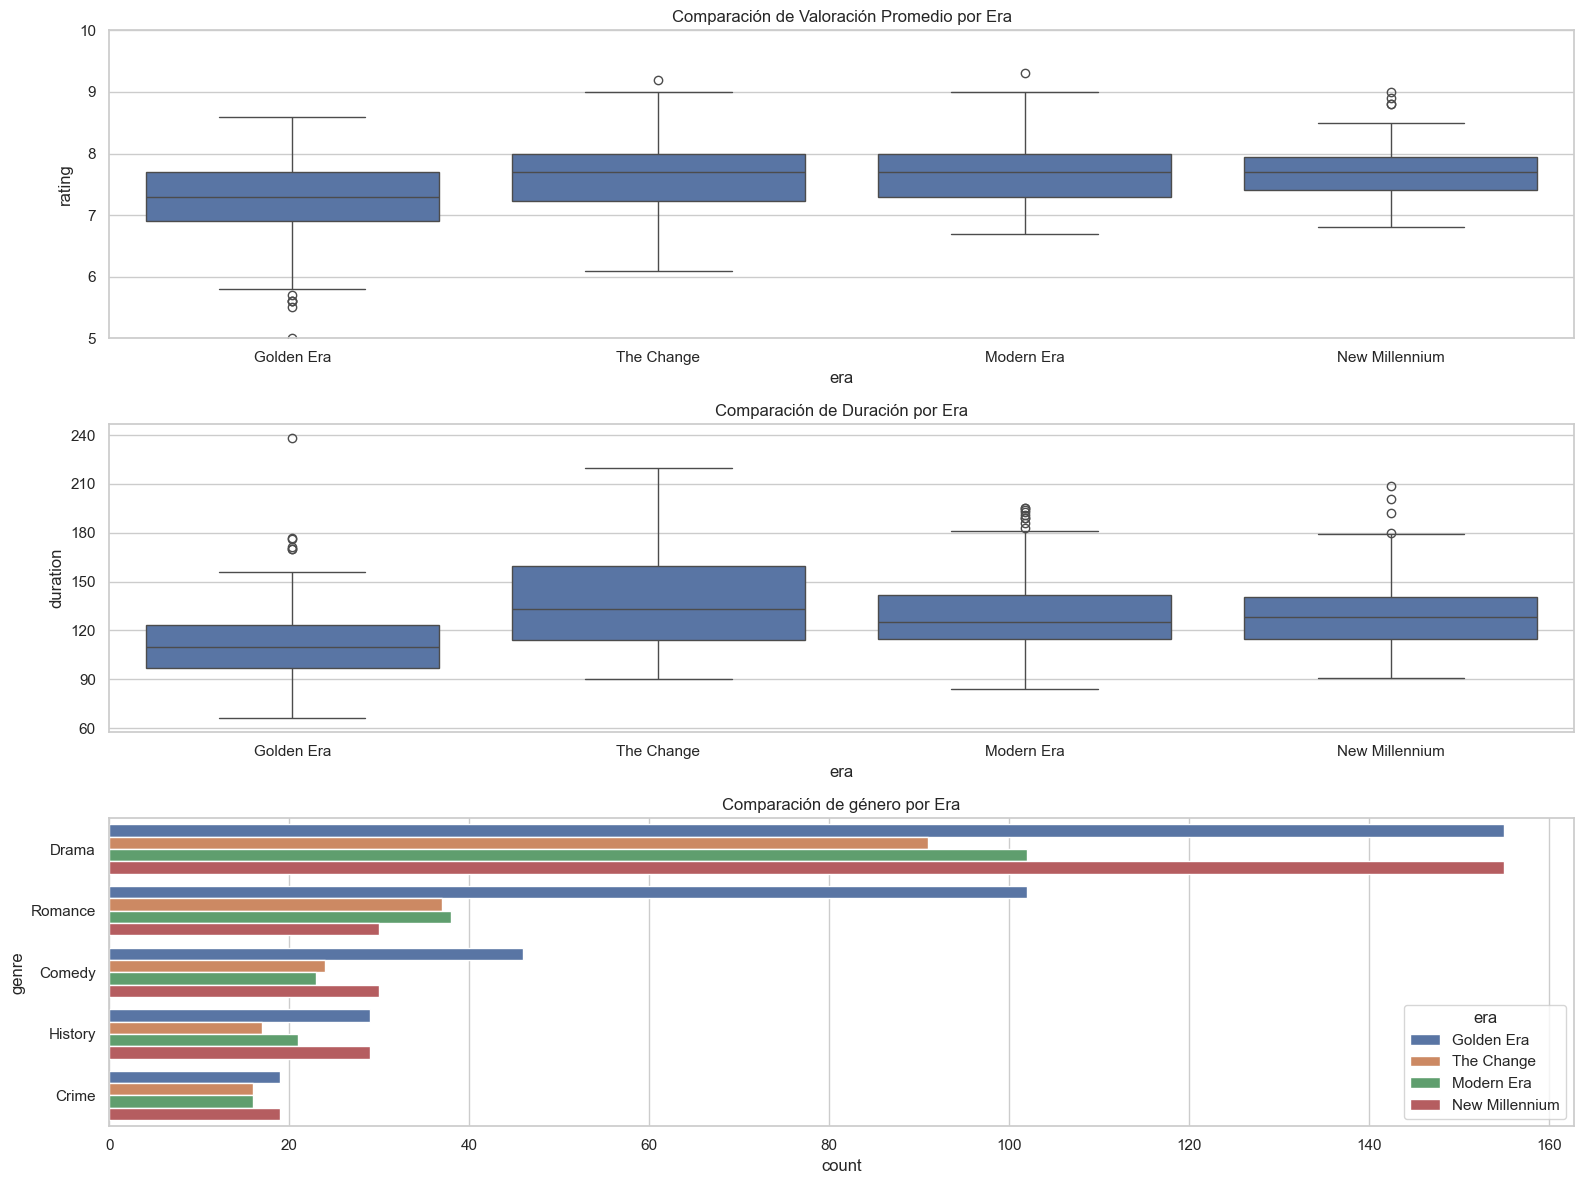

In [120]:
# Y COMPARO POR ERAS

df_exploded = df.explode('genre')

df_exploded['genre_position'] = df_exploded.groupby(level=0).cumcount() + 1
column_order = ['year_film', 'year_ceremony', 'ceremony', 'film', 'winner',
                'original_language', 'original_title', 'release_date', 'vote_average',
                'genre_position', 'genre', 'rating', 'duration', 'era']

df_exploded = df_exploded[column_order]
df_exploded

sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))

# Comparación de Valoración Promedio
plt.subplot(3, 1, 1)
sns.boxplot(x='era', y='rating', data=df)
plt.ylim(df['rating'].min(),10)
plt.title('Comparación de Valoración Promedio por Era')

# Comparación de Duración
plt.subplot(3, 1, 2)
plt.yticks
sns.boxplot(x='era', y='duration', data=df)
y_min = df['duration'].min()
y_max = df['duration'].max()
plt.yticks(np.arange(np.floor(y_min/30)*30, np.ceil(y_max/30)*30 + 30, 30))
plt.title("Comparación de Duración por Era")

# Comparación de Géneros
plt.subplot(3, 1, 3)
top_genres = df_exploded['genre'].value_counts().nlargest(5).index
df_top_genres = df_exploded[df_exploded['genre'].isin(top_genres)]
sns.countplot(y='genre', hue='era', data=df_top_genres, order=df_top_genres['genre'].value_counts().index)
plt.title('Comparación de género por Era')


plt.tight_layout()
plt.show()

IMDB empezó en el 90  

Comparación de Valoración Promedio por Era
- curioso como las cajas no pasan del 8
- muy pocas pelis con más de un 9
- la golden era tiene unos ratings bajisimos

Comparación de Duración por Era
- pensaba que las pelis eran cada vez más largas
- wtf lo que el viento se llevó dura 4 horas

Comparación de Género por Era
- aplastante victoria de drama
- romance a tope en la golden age

### Género
La mayoría de películas estan listadas con varios géneros, estudio el porcentaje de cada género entre el total de nominaciones
- géneros all time
- géneros década

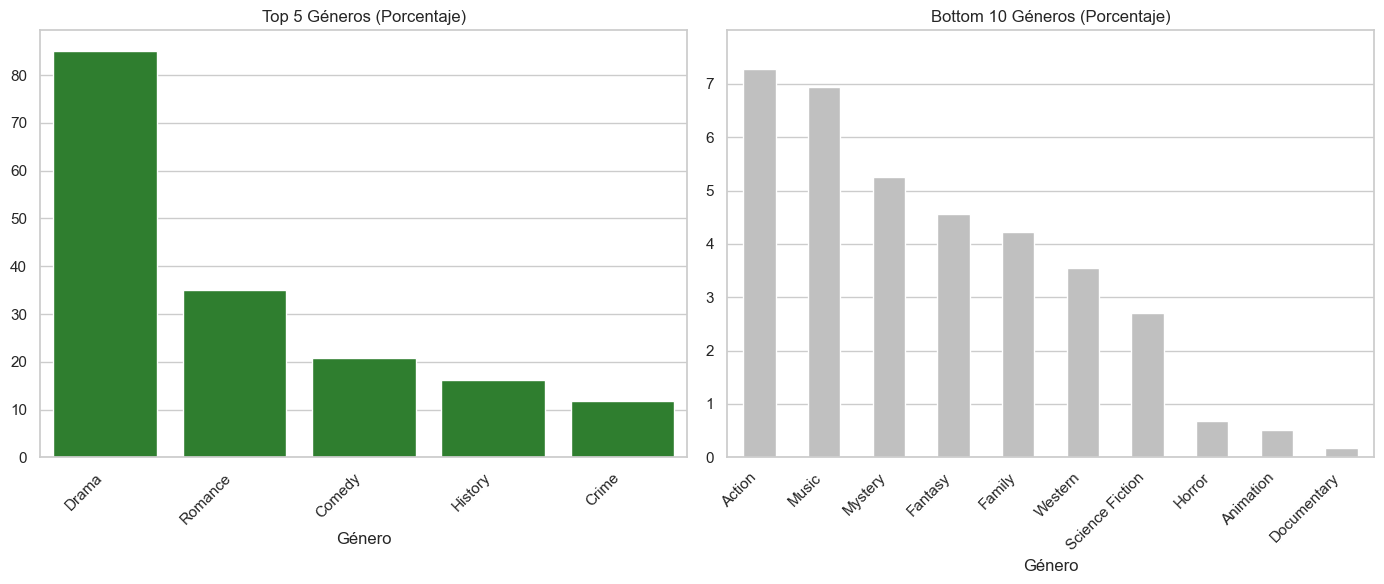

In [121]:
# Obtener los géneros más y menos populares
top_genres = df_exploded['genre'].value_counts().nlargest(5).index
bottom_genres = df_exploded['genre'].value_counts().nsmallest(10).index

# Calcular porcentajes
total_entries = len(df)
top_genres_percentage = df_exploded['genre'].value_counts().nlargest(5) / total_entries * 100
bottom_genres_percentage = df_exploded['genre'].value_counts().nsmallest(10) / total_entries * 100

# Figure
plt.figure(figsize=(14, 6))

# Top
plt.subplot(1, 2, 1)
sns.barplot(x=top_genres_percentage.index, y=top_genres_percentage.values, color='forestgreen')
plt.title('Top 5 Géneros (Porcentaje)')
plt.xlabel('Género')
plt.ylabel("")
plt.xticks(rotation=45, ha='right')

# Bottom
plt.subplot(1, 2, 2)
sns.barplot(x=bottom_genres_percentage.index, y=bottom_genres_percentage.values, color='silver', saturation=.3, width=.5, order=bottom_genres[::-1])
plt.title('Bottom 10 Géneros (Porcentaje)')
plt.xlabel('Género')
plt.xticks(rotation=45, ha='right')
plt.yticks(range(0, 8, 1))
plt.ylabel("")
plt.ylim(0, 8)
plt.tight_layout()
plt.show()


In [122]:
df_exploded[df_exploded["genre"]=="Documentary"]

,year_film,year_ceremony,ceremony,film,winner,original_language,original_title,release_date,vote_average,genre_position,genre,rating,duration,era
441,2004,2005,77,Finding Neverland,False,en,Finding Neverland,2004-10-17,7.321,2,Documentary,7.7,106.0,New Millennium


- De 590 películas que tengo el género Drama aparece 500, más del 80%
- El único documental que hay no es un docu, es un biopic
- Terror: historicamente las pelis de miedo son nominadas a categorias tecnicas o de acting
    - carrie 4 nominaciones
    - rosemarys baby 2 nominaciones
    - psycho 4 nominaciones

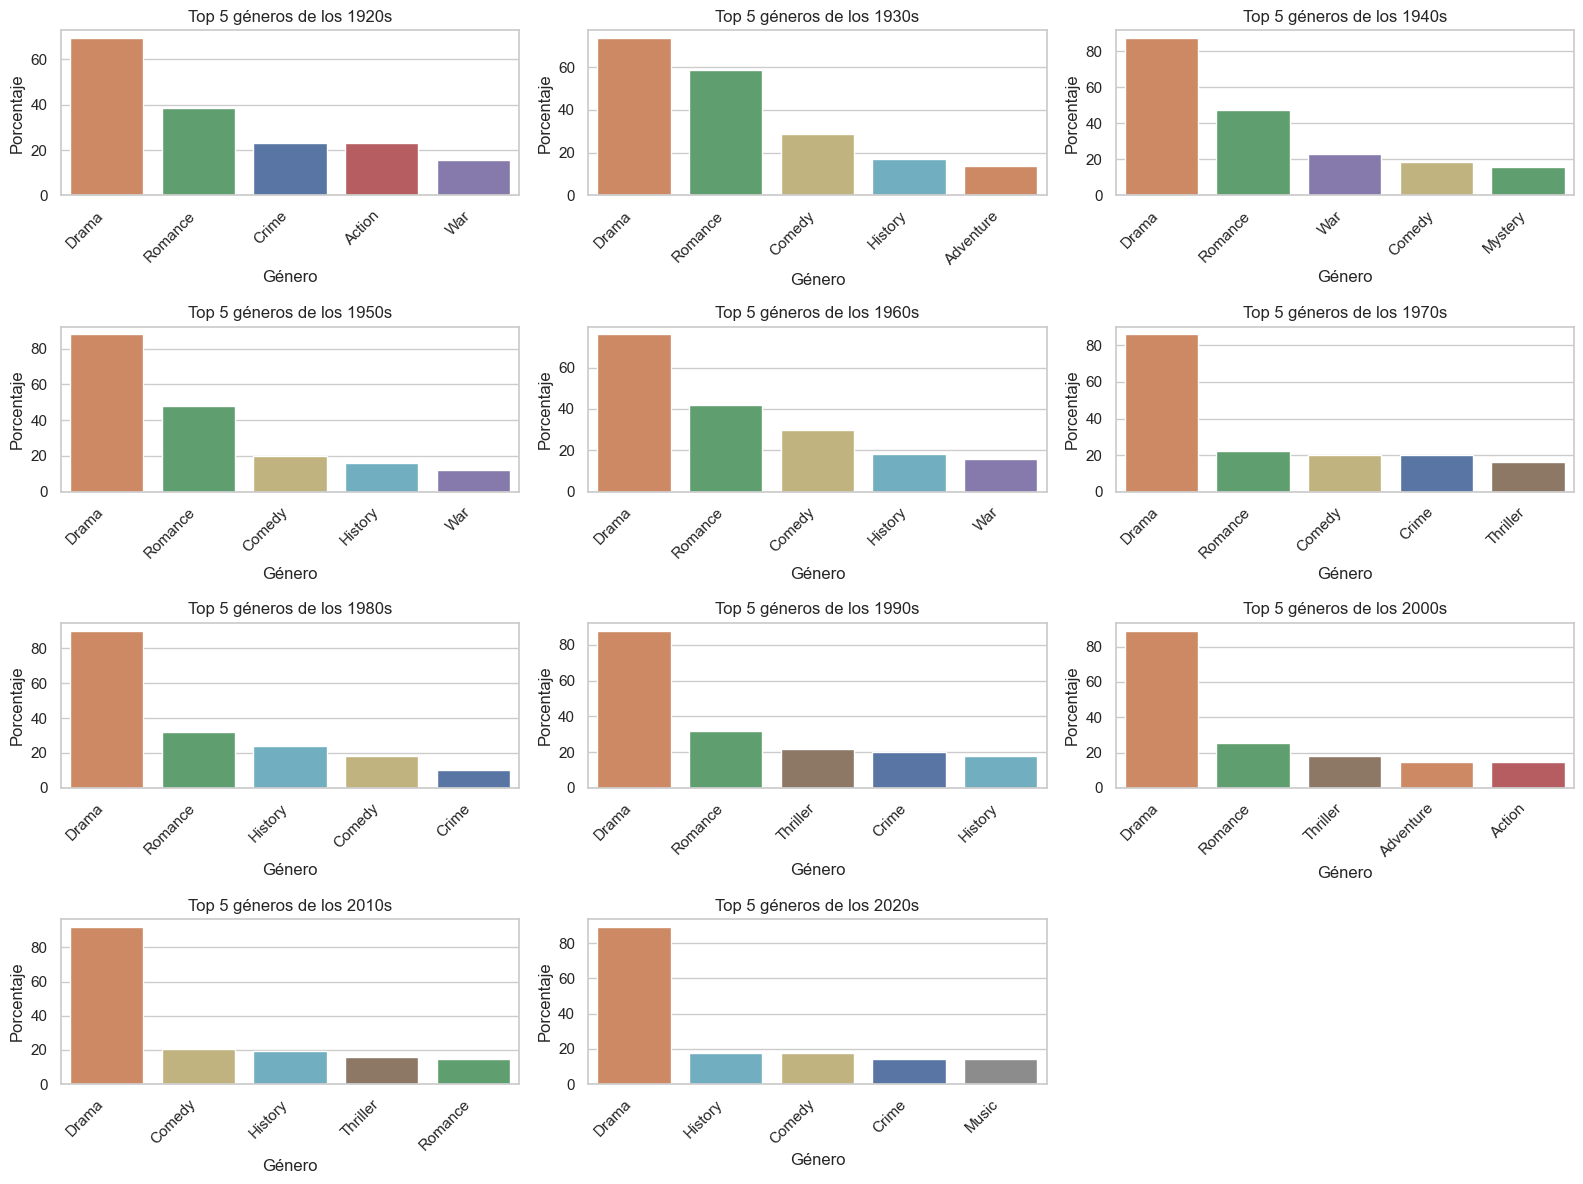

In [123]:
# Crear una nueva columna 'decade' en el DataFrame
df['decade'] = df['year_film'] // 10 * 10

# Obtener el número total de décadas
num_decades = len(df['decade'].unique())

# Crear subgráficos para la distribución de géneros por década
plt.figure(figsize=(16, 12))
rows = (num_decades // 3) + (num_decades % 3 > 0)  # Calcular el número de filas necesarias

for i, decade in enumerate(sorted(df['decade'].unique())):
    plt.subplot(rows, 3, i + 1)

    # Datos
    top_genres = df[df['decade'] == decade].explode('genre')['genre'].value_counts().head(5)
    all_genres = df['genre'].explode().unique()

    # Calcular porcentajes
    total_movies_in_decade = len(df[df['decade'] == decade])
    percentages = (top_genres / total_movies_in_decade) * 100

    # Asignar un color a cada género
    palette = sns.color_palette("deep", n_colors=len(all_genres))
    genre_color_mapping = dict(zip(all_genres, palette))
    colors = [genre_color_mapping[genre] for genre in top_genres.index]

    # Graficar con porcentajes
    sns.barplot(x=top_genres.index, y=percentages.values, order=top_genres.index,
                palette=colors, hue=top_genres.index)
    
    plt.title(f'Top 5 géneros de los {decade}s')
    plt.xlabel('Género')
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


- drama y romance(casi) dominan década tras década
    - despiertan emociones en el publico
    - relatable content
    - catarsis emocional
    - impacto duradero

- war:
    - 20s: venimos de la WWI
    - 40s: WWII
    - 50s: korea
    - 60s: vietnam

### Distribución de fechas de lanzamiento

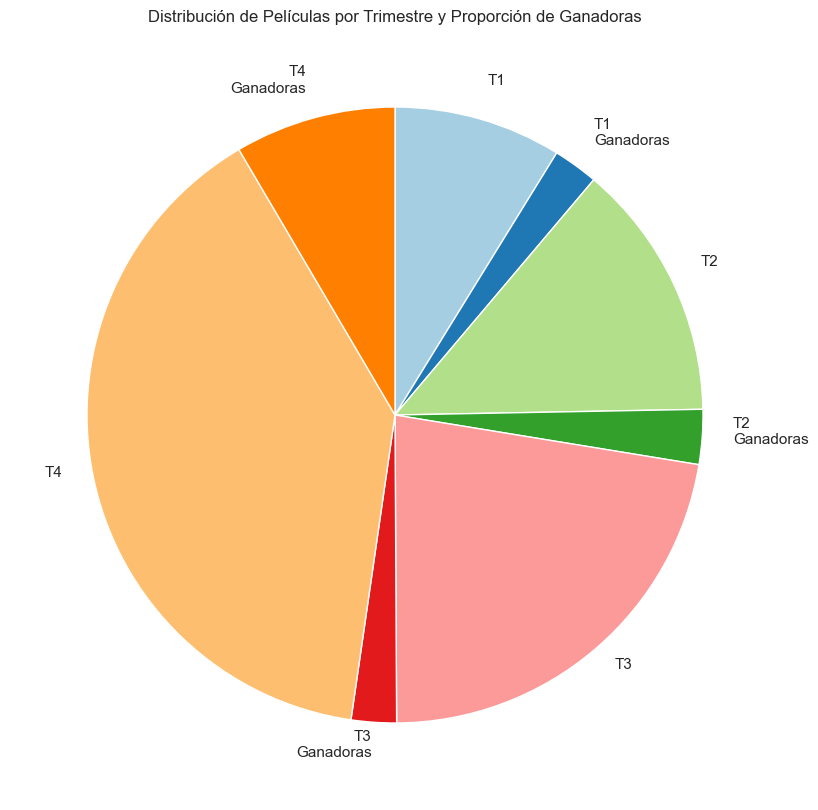

In [124]:
# Extrae el trimestre de cada fecha de lanzamiento
df['release_quarter'] = df['release_date'].dt.quarter

# Mapea los números del trimestre a nombres
quarter_mapping = {1: 'T1', 2: 'T2', 3: 'T3', 4: 'T4'}
df['release_quarter'] = df['release_quarter'].map(quarter_mapping)

# Crea un DataFrame auxiliar con información de ganadoras por trimestre
info_ganadoras = df[df['winner']].groupby('release_quarter').size()

# Ordena los trimestres cronológicamente
quarters_order = ['T1', 'T2', 'T3', 'T4']

# Crea un gráfico de tarta (pie plot) para mostrar la distribución de fechas de lanzamiento por trimestre
plt.figure(figsize=(10, 10))


# Inicializa listas para etiquetas y porcentajes
labels_all = []
porcentajes_all = []

for i, quarter in enumerate(quarters_order):
    # Filtra las películas del trimestre actual
    subset_df = df[df['release_quarter'] == quarter]
    
    # Cuenta la frecuencia de películas por trimestre
    counts_per_quarter = subset_df.shape[0]
    
    # Cuenta la frecuencia de películas ganadoras por trimestre
    counts_ganadoras = info_ganadoras.get(quarter, default=0)
    
    # Calcula la proporción de ganadoras en el trimestre
    porcentaje_ganadoras = (counts_ganadoras / counts_per_quarter) * 100
    
    # Etiquetas para el gráfico
    labels = [f'{quarter}\n', f'{quarter}\nGanadoras\n']
    
    # Agrega las etiquetas y porcentajes a las listas
    labels_all.extend(labels)
    porcentajes_all.extend([counts_per_quarter - counts_ganadoras, counts_ganadoras])

# Crea el gráfico de tarta
plt.pie(porcentajes_all, labels=labels_all, startangle=90,
        counterclock=False, colors=sns.set_palette("Paired"))

plt.title('Distribución de Películas por Trimestre y Proporción de Ganadoras')
plt.show()


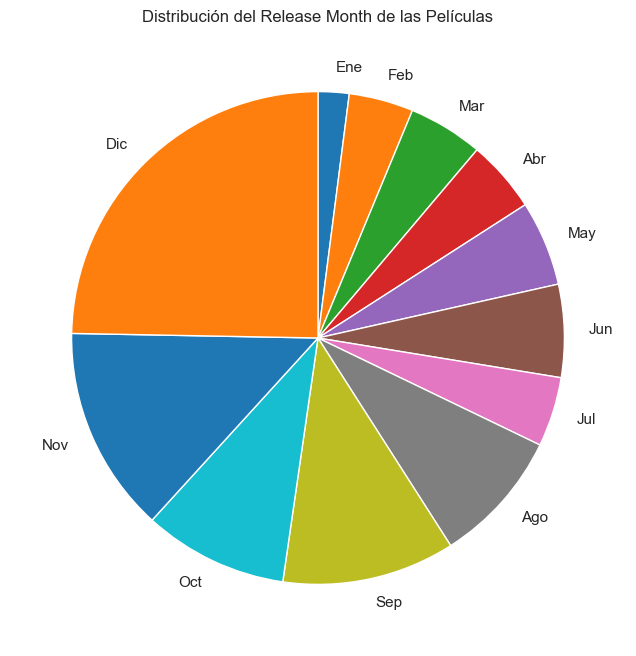

In [125]:


# Extraer el mes y crear una nueva columna 'release_month'
df['release_month'] = df['release_date'].dt.month

# Contar la frecuencia de cada mes y ordenar por mes
month_counts = df['release_month'].value_counts().sort_index()

# Crear el pie plot con labels de meses
month_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

plt.figure(figsize=(8, 8))
plt.pie(month_counts, labels=month_labels, startangle=90, colors=sns.color_palette("tab10"), counterclock=False)

plt.title('Distribución del Release Month de las Películas')
plt.show()


Las nominaciones de los oscars son principalmente peliculas estrenadas a finales de año, especialmente en el mes de diciembre

### Duracion

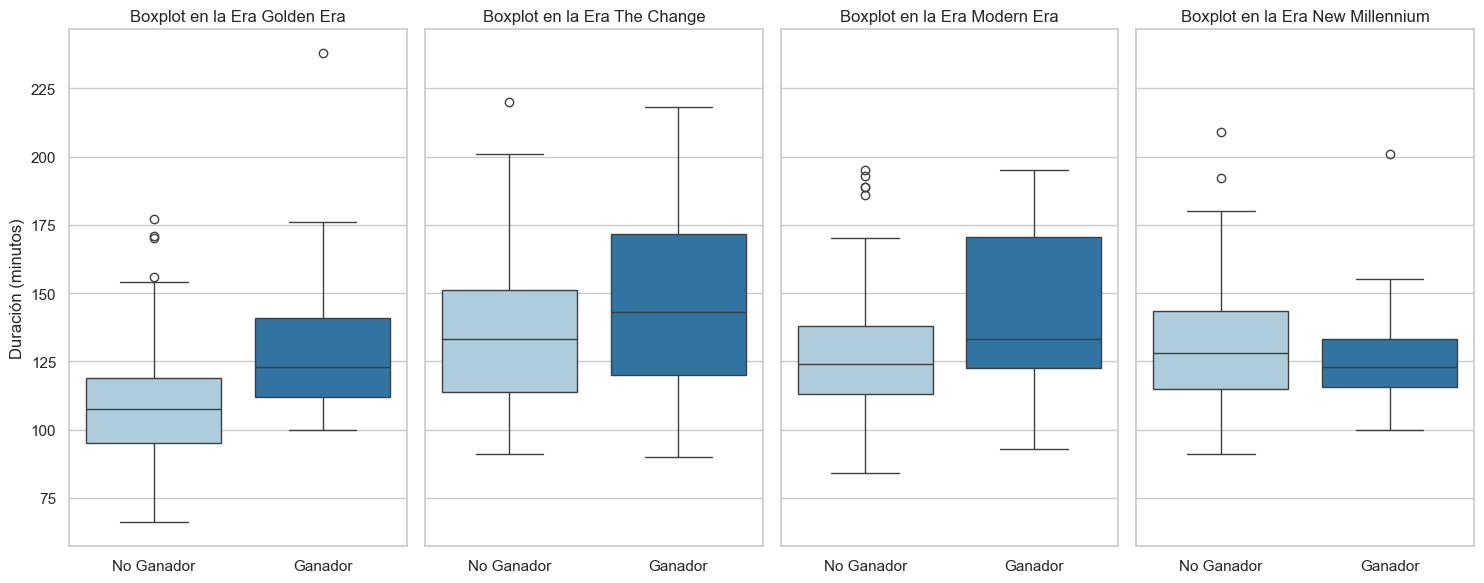

In [126]:

# Crear subplots para cada era
eras = df['era'].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(eras), figsize=(15, 6), sharey=True)

for i, era in enumerate(eras):
    era_data = df[df['era'] == era]
    sns.boxplot(data=era_data, x='winner', y='duration', ax=axes[i], hue="winner", legend=False)
    axes[i].set_title(f'Boxplot en la Era {era}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Duración (minutos)')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['No Ganador', 'Ganador'])

plt.tight_layout()
plt.show()


### Idioma

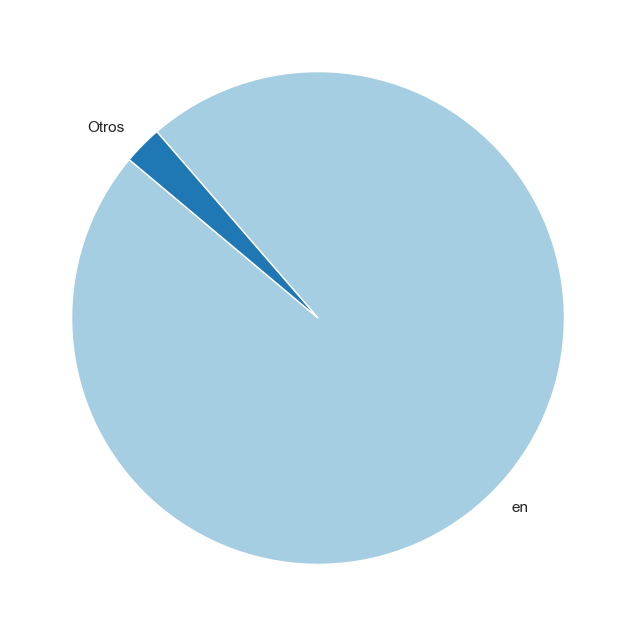

In [ ]:
language_counts = df['original_language'].value_counts()

# Agrupar todos los idiomas, excepto 'en', en 'Otros'
language_counts_others = language_counts.copy()
language_counts_others['Otros'] = language_counts[language_counts.index != 'en'].sum()
language_counts_others = language_counts_others.drop(language_counts[language_counts.index != 'en'].index)

# Crear el gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(language_counts_others, labels=language_counts_others.index, startangle=140)
plt.title('')
plt.show()


In [ ]:
df[(df["winner"]==True)&(df["original_language"]!= "en")]

,year_film,year_ceremony,ceremony,film,winner,original_language,original_title,release_date,vote_average,genre,rating,duration,era,decade,release_quarter,release_month
485,2011,2012,84,The Artist,True,fr,The Artist,2011-10-12,7.458,"[Drama, Comedy, Romance]",7.9,100.0,New Millennium,2010,T4,10
562,2019,2020,92,Parasite,True,ko,기생충,2019-05-30,8.511,"[Comedy, Thriller, Drama]",8.5,132.0,New Millennium,2010,T2,5


### Rating / Winner

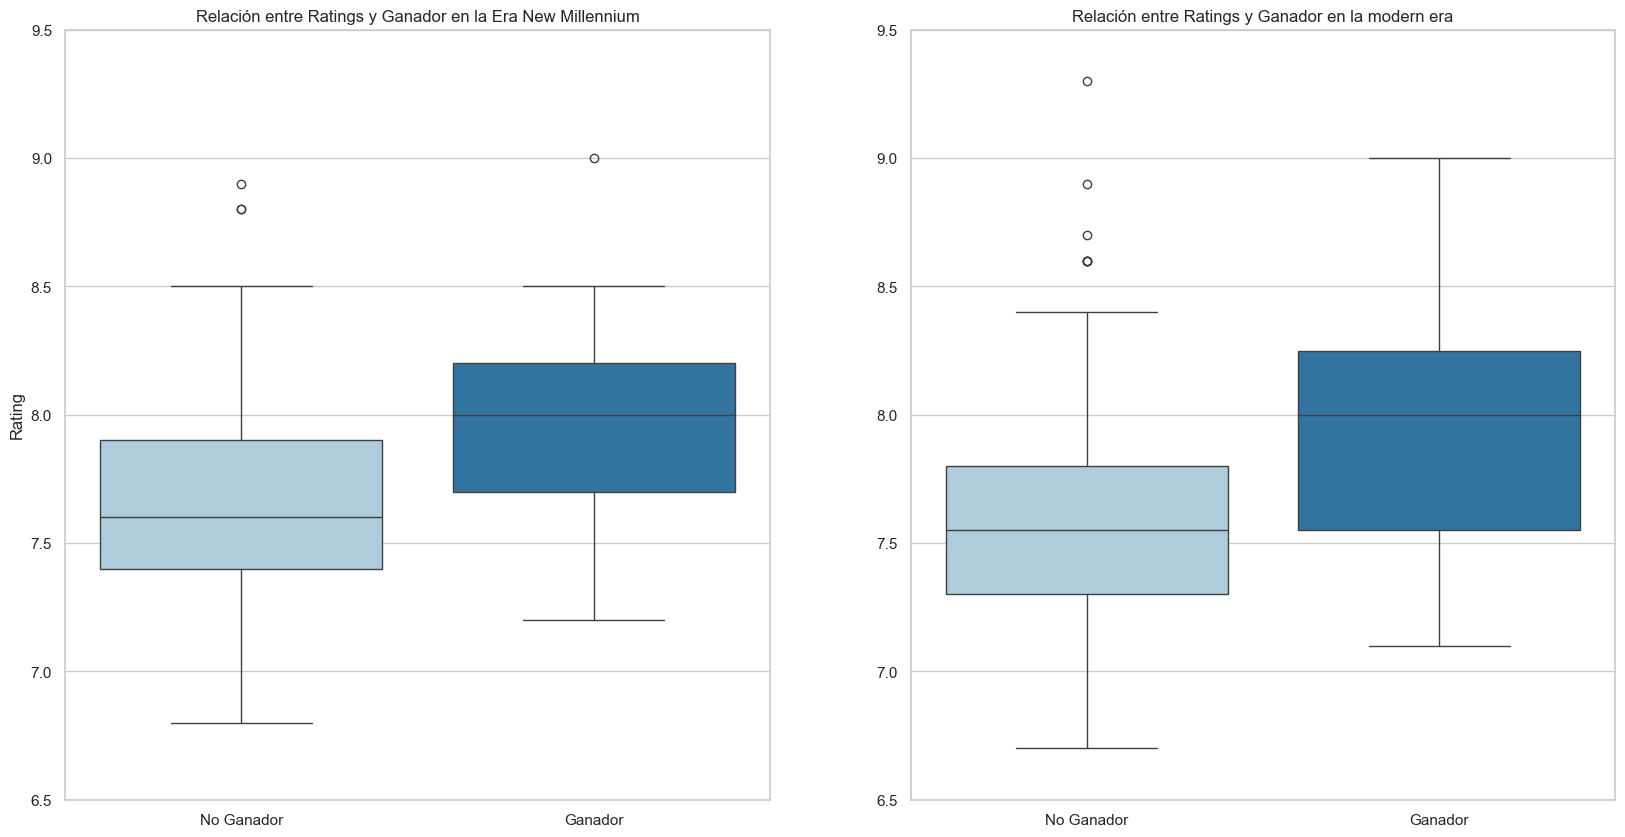

In [ ]:

plt.figure(figsize=(20,10))
ylim_range = (new_millennium['rating'].min()-.3, 9.5)

plt.subplot(1,2,1)
sns.boxplot(data=new_millennium, x='winner', y='rating',hue="winner", legend=False)
plt.title('Relación entre Ratings y Ganador en la Era New Millennium')
plt.xlabel('')
plt.ylabel('Rating')
plt.ylim(ylim_range)
plt.xticks([0, 1], ['No Ganador', 'Ganador'])

plt.subplot(1,2,2)
sns.boxplot(data=modern_era, x='winner', y='rating',hue="winner", legend=False)
plt.title('Relación entre Ratings y Ganador en la modern era')
plt.xlabel('')
plt.ylabel('')
plt.ylim(ylim_range)
plt.xticks([0, 1], ['No Ganador', 'Ganador'])
plt.show()


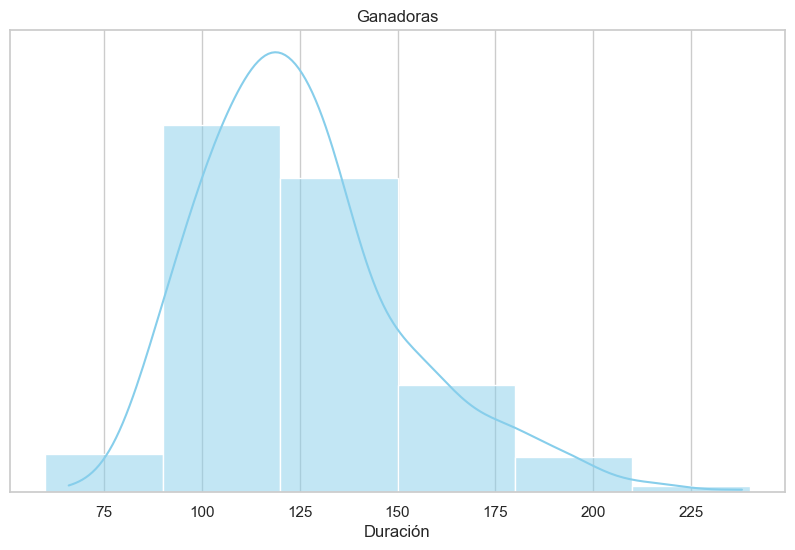

In [127]:
# Crear el histplot
plt.figure(figsize=(10, 6))
binwidth = 15
bin_edges = [i * 30 for i in range(int(df['duration'].min() // 30),
                                   int(df['duration'].max() // 30) + 2)]

sns.histplot(df['duration'], bins=bin_edges, kde=True, color='skyblue')
plt.title('Ganadoras')
plt.xlabel('Duración')
plt.ylabel('')
plt.yticks([])
plt.show()


In [ ]:
df[(df["winner"]==True)&(df["original_language"]!= "en")]

,year_film,year_ceremony,ceremony,film,winner,original_language,original_title,release_date,vote_average,genre,rating,duration,era,decade,release_quarter,release_month
485,2011,2012,84,The Artist,True,fr,The Artist,2011-10-12,7.458,"[Drama, Comedy, Romance]",7.9,100.0,New Millennium,2010,T4,10
562,2019,2020,92,Parasite,True,ko,기생충,2019-05-30,8.511,"[Comedy, Thriller, Drama]",8.5,132.0,New Millennium,2010,T2,5
